# Import Libraries

In [1]:
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import os
import glob
from PIL import Image, UnidentifiedImageError
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import random
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import categorical_accuracy, CategoricalAccuracy
from tensorflow.keras.models import model_from_json

2.2.0


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11711106674210954415,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5929540510916184627
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1421980467
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17463846426759019957
 physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14234200500909201443
 physical_device_desc: "device: XLA_GPU device"]

# Import Models

## VGG16

In [3]:
from tensorflow.keras.applications import vgg16
model_vgg16=vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

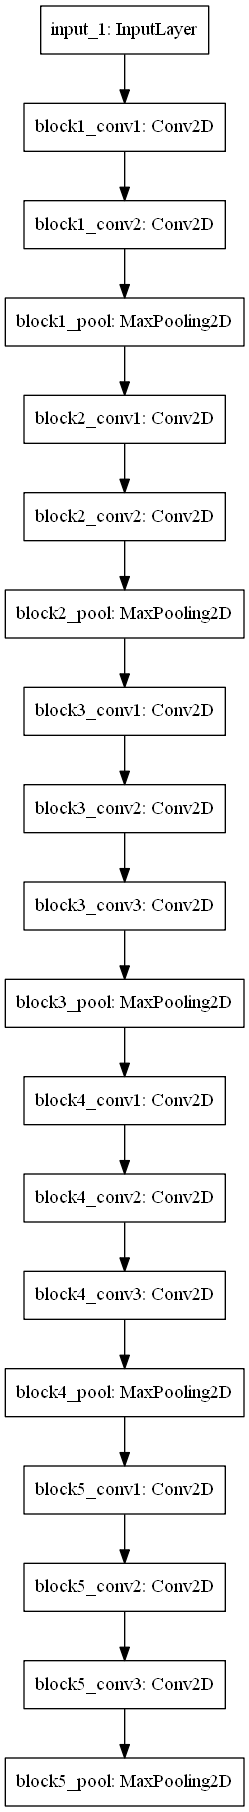

In [4]:
plot_model(model_vgg16)

# ResNet18

In [5]:
model_resnet18 = model_from_json(open('model_resnet18.json', 'r').read())
model_resnet18.load_weights("model_resnet18.h5")

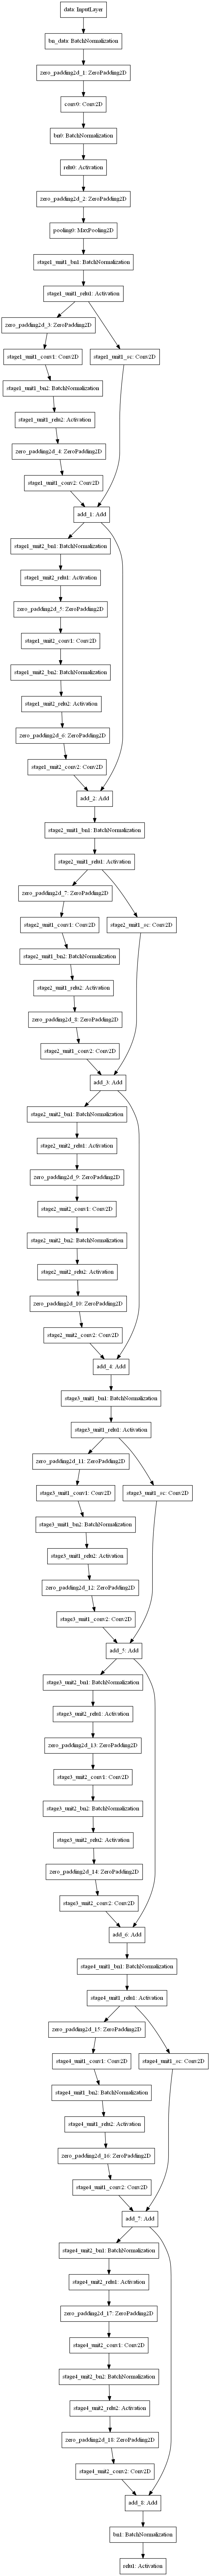

In [6]:
plot_model(model_resnet18)

In [7]:
model_resnet18.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

# Devide model into for TransferLearning(tfl) and for FineTuning(fnt)

In [8]:
def trainable_to_nontrainable(model):
    """
    Transfer trainable variables to non-trainable variables
    """
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
    return model

In [9]:
def transfer_learning_model(model):
    model1 = clone_model(model)
    model1 = trainable_to_nontrainable(model1)
    return model1

In [10]:
def fine_tune_for_vgg16(model):
    model1 = clone_model(model)
    model1 = trainable_to_nontrainable(model1)
    model1.layers[-4].trainable=True
    model1.layers[-3].trainable=True
    model1.layers[-2].trainable=True
    return model1

In [11]:
def fine_tune_for_resnet18(model):
    model1 = clone_model(model)
    model1 = trainable_to_nontrainable(model1)
    model1.layers[-11].trainable=True
    model1.layers[-10].trainable=True
    model1.layers[-9].trainable=True
    model1.layers[-8].trainable=True
    model1.layers[-7].trainable=True
    model1.layers[-6].trainable=True
    model1.layers[-5].trainable=True
    model1.layers[-4].trainable=True
    model1.layers[-3].trainable=True
    model1.layers[-2].trainable=True
    model1.layers[-1].trainable=True
    return model1

# Prepair Datasets

In [2]:
def prepair_dataset(folder_name):
    """
    Get image fron folders
    resize image_shape to (224, 224)
    """
    master_list = []
    for i in glob.glob("./{}/*".format(folder_name)):
        pic_list = glob.glob(i + "/" + "*")
        temp_list = np.empty((len(pic_list), 224, 224, 3) ,dtype=np.uint8)
        k = 0
        for j, jdx in enumerate(pic_list):
            try:
                img = Image.open(jdx)
                img = np.array(img, dtype=np.uint8)
                img = cv2.resize(img, (224, 224))
                if img.ndim == 3 and img.shape[2] == 3:
                    temp_list[k, :, :, :] = img[:, :, :]
                    k += 1
            except UnidentifiedImageError:
                print(j)
                continue

        master_list.append(temp_list)
    return master_list

In [3]:
kimtesu_datasets = prepair_dataset("AnimationPicture")

C:\Users\takayuki\.conda\envs\keras-gpu\lib\site-packages\PIL\Image.py:2957: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23
24
64


In [4]:
y3 = np.array([np.array([[1.0, 0.0, 0.0] for i in range(len(kimtesu_datasets[0]))]).astype("float32"),
      np.array([[0.0, 1.0, 0.0] for i in range(len(kimtesu_datasets[1]))]).astype("float32"),
      np.array([[0.0, 0.0, 1.0] for i in range(len(kimtesu_datasets[2]))]).astype("float32")])

In [5]:
for i, idx in enumerate(kimtesu_datasets):
    if i == 0:
        X_train, X_test, y_train, y_test = train_test_split(kimtesu_datasets[i][0:70, :, :, :], y3[i][0:70, :], test_size=0.3, random_state=0)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(kimtesu_datasets[i][0:70, :, :, :], y3[i][0:70, :], test_size=0.3, random_state=0)
        X_train = np.concatenate((X_train, X_train1))
        X_test = np.concatenate((X_test, X_test1))
        y_train = np.concatenate((y_train, y_train1))
        y_test = np.concatenate((y_test, y_test1))

In [6]:
def data_augumentation(X, y):
    augumented_data = np.empty(X.shape, dtype=np.uint8)
    for i, idx in enumerate(X):
        augumented_data[i, :, :, :] = cv2.flip(idx, 1)
    return np.concatenate((X, augumented_data)), np.concatenate((y, y))

# Training

In [17]:
def training_model(model_):
    model = Sequential()
    model.add(model_)
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation=softmax))

    model.compile(loss = categorical_crossentropy, optimizer = "adam", metrics=["accuracy"])
    #model.summary()
    return model

In [18]:
def save_result(array1, array2):

    n1 = np.array( [np.array([i, np.nan, np.nan]) for i in array1] ).ravel()
    n1 = n1.reshape(15, 1)
    n2 = np.concatenate( (array2[0],array2[1],array2[2], array2[3], array2[4]))
    n3 = np.hstack([n2, n1])
    df = pd.DataFrame(n3)
    return df

In [18]:
vgg16_tfl_nodataaugument_acc = []
vgg16_tfl_nodataaugument_cm = []
vgg16_tfl_nodataaugument_model = []
for i in range(5):
    model = training_model(transfer_learning_model(model_vgg16))
    #X_train_augumented, y_train_augumented = data_augumentation(X_train, y_train)
    model.fit(X_train, y_train, batch_size=4, epochs=50)#, callbacks=[es])

    y_pred = np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))])
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_pred, y_true)

    cm = confusion_matrix(
        np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))]),
        np.argmax(y_test, axis=1)
    )
    vgg16_tfl_nodataaugument_acc.append(acc)
    vgg16_tfl_nodataaugument_cm.append(cm)
    #vgg16_tfl_nodataaugument_model.append(model)

Epoch 1/50
34/34 [==============================] - 3s 89ms/step - loss: 19.7821 - accuracy: 0.2963
Epoch 2/50
34/34 [==============================] - 2s 69ms/step - loss: 11.7522 - accuracy: 0.3556
Epoch 3/50
34/34 [==============================] - 2s 69ms/step - loss: 14.1808 - accuracy: 0.3926
Epoch 4/50
34/34 [==============================] - 2s 69ms/step - loss: 8.2494 - accuracy: 0.3481
Epoch 5/50
34/34 [==============================] - 2s 69ms/step - loss: 8.2627 - accuracy: 0.4074
Epoch 6/50
34/34 [==============================] - 2s 69ms/step - loss: 5.9979 - accuracy: 0.5111
Epoch 7/50
34/34 [==============================] - 2s 69ms/step - loss: 8.7623 - accuracy: 0.4000
Epoch 8/50
34/34 [==============================] - 2s 69ms/step - loss: 7.7112 - accuracy: 0.4593
Epoch 9/50
34/34 [==============================] - 2s 69ms/step - loss: 6.1369 - accuracy: 0.4667
Epoch 10/50
34/34 [==============================] - 2s 69ms/step - loss: 5.5518 - accuracy: 0.5556
Epoch 

34/34 [==============================] - 2s 70ms/step - loss: 1.0024 - accuracy: 0.8815
Epoch 34/50
34/34 [==============================] - 2s 70ms/step - loss: 0.7737 - accuracy: 0.8815
Epoch 35/50
34/34 [==============================] - 2s 70ms/step - loss: 0.6194 - accuracy: 0.9111
Epoch 36/50
34/34 [==============================] - 2s 70ms/step - loss: 1.3963 - accuracy: 0.8741
Epoch 37/50
34/34 [==============================] - 2s 70ms/step - loss: 2.5660 - accuracy: 0.7926
Epoch 38/50
34/34 [==============================] - 2s 70ms/step - loss: 3.2982 - accuracy: 0.7926
Epoch 39/50
34/34 [==============================] - 2s 70ms/step - loss: 1.2042 - accuracy: 0.8593
Epoch 40/50
34/34 [==============================] - 2s 70ms/step - loss: 1.1170 - accuracy: 0.8667
Epoch 41/50
34/34 [==============================] - 2s 70ms/step - loss: 1.4994 - accuracy: 0.8815
Epoch 42/50
34/34 [==============================] - 2s 70ms/step - loss: 0.9211 - accuracy: 0.8741
Epoch 43/50


34/34 [==============================] - 2s 69ms/step - loss: 6.7191 - accuracy: 0.6296
Epoch 16/50
34/34 [==============================] - 2s 70ms/step - loss: 4.7858 - accuracy: 0.7556
Epoch 17/50
34/34 [==============================] - 2s 69ms/step - loss: 5.4121 - accuracy: 0.6815
Epoch 18/50
34/34 [==============================] - 2s 70ms/step - loss: 8.4215 - accuracy: 0.6370
Epoch 19/50
34/34 [==============================] - 2s 70ms/step - loss: 5.0856 - accuracy: 0.7185
Epoch 20/50
34/34 [==============================] - 2s 70ms/step - loss: 2.8449 - accuracy: 0.7481
Epoch 21/50
34/34 [==============================] - 2s 72ms/step - loss: 2.7246 - accuracy: 0.7852
Epoch 22/50
34/34 [==============================] - 2s 70ms/step - loss: 6.3036 - accuracy: 0.6741
Epoch 23/50
34/34 [==============================] - 2s 70ms/step - loss: 9.5369 - accuracy: 0.6370
Epoch 24/50
34/34 [==============================] - 2s 70ms/step - loss: 7.3838 - accuracy: 0.6593
Epoch 25/50


34/34 [==============================] - 2s 70ms/step - loss: 0.7420 - accuracy: 0.9037
Epoch 48/50
34/34 [==============================] - 2s 70ms/step - loss: 0.7952 - accuracy: 0.8963
Epoch 49/50
34/34 [==============================] - 2s 71ms/step - loss: 1.2415 - accuracy: 0.8667
Epoch 50/50
34/34 [==============================] - 2s 70ms/step - loss: 4.4698 - accuracy: 0.7185


In [56]:
save_result(vgg16_tfl_nodataaugument_acc, vgg16_tfl_nodataaugument_cm).to_csv("vgg16_tfl_nodataaugument.csv", index=None)

In [19]:
resnet18_tfl_nodataaugument_acc = []
resnet18_tfl_nodataaugument_cm = []
resnet18_tfl_nodataaugument_model = []
for i in range(5):
    model = training_model(transfer_learning_model(model_resnet18))
    #X_train_augumented, y_train_augumented = data_augumentation(X_train, y_train)
    model.fit(X_train, y_train, batch_size=4, epochs=50)#, callbacks=[es])

    y_pred = np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))])
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_pred, y_true)

    cm = confusion_matrix(
        np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))]),
        np.argmax(y_test, axis=1)
    )
    resnet18_tfl_nodataaugument_acc.append(acc)
    resnet18_tfl_nodataaugument_cm.append(cm)
    #resnet18_tfl_nodataaugument_model.append(model)

Epoch 1/50
34/34 [==============================] - 1s 26ms/step - loss: 107590.9844 - accuracy: 0.4074
Epoch 2/50
34/34 [==============================] - 1s 19ms/step - loss: 70429.7344 - accuracy: 0.4815
Epoch 3/50
34/34 [==============================] - 1s 19ms/step - loss: 50032.8945 - accuracy: 0.4296
Epoch 4/50
34/34 [==============================] - 1s 19ms/step - loss: 36877.0664 - accuracy: 0.5185 0s - loss: 39809.6328 - accuracy: 
Epoch 5/50
34/34 [==============================] - 1s 19ms/step - loss: 53555.0312 - accuracy: 0.4963
Epoch 6/50
34/34 [==============================] - 1s 19ms/step - loss: 32381.1660 - accuracy: 0.5556
Epoch 7/50
34/34 [==============================] - 1s 19ms/step - loss: 51474.7500 - accuracy: 0.5556
Epoch 8/50
34/34 [==============================] - 1s 19ms/step - loss: 30408.3496 - accuracy: 0.6593
Epoch 9/50
34/34 [==============================] - 1s 19ms/step - loss: 44082.4766 - accuracy: 0.6222
Epoch 10/50
34/34 [==================

34/34 [==============================] - 1s 26ms/step - loss: 45424.5781 - accuracy: 0.5630
Epoch 8/50
34/34 [==============================] - 1s 22ms/step - loss: 36419.4258 - accuracy: 0.6370 0s - loss: 39718.6992 - accuracy: 0.
Epoch 9/50
34/34 [==============================] - 1s 19ms/step - loss: 23297.1973 - accuracy: 0.6815
Epoch 10/50
34/34 [==============================] - 1s 20ms/step - loss: 23244.1016 - accuracy: 0.6519
Epoch 11/50
34/34 [==============================] - 1s 21ms/step - loss: 29845.9141 - accuracy: 0.6667
Epoch 12/50
34/34 [==============================] - 1s 21ms/step - loss: 17191.6094 - accuracy: 0.7556
Epoch 13/50
34/34 [==============================] - 1s 19ms/step - loss: 17029.3281 - accuracy: 0.7630
Epoch 14/50
34/34 [==============================] - 1s 19ms/step - loss: 27010.1387 - accuracy: 0.7259 0s - loss: 41358.9102 - ac
Epoch 15/50
34/34 [==============================] - 1s 19ms/step - loss: 25696.3984 - accuracy: 0.7111
Epoch 16/50
34

In [57]:
save_result(resnet18_tfl_nodataaugument_acc, resnet18_tfl_nodataaugument_cm).to_csv("resnet18_tfl_nodataaugument.csv", index=None)

In [19]:
vgg16_ftn_nodataaugument_acc = []
vgg16_ftn_nodataaugument_cm = []
vgg16_ftn_nodataaugument_model = []
for i in range(5):
    model = training_model(fine_tune_for_vgg16(model_vgg16))
    #X_train_augumented, y_train_augumented = data_augumentation(X_train, y_train)
    model.fit(X_train, y_train, batch_size=4, epochs=50)#, callbacks=[es])

    y_pred = np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))])
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_pred, y_true)

    cm = confusion_matrix(
        np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))]),
        np.argmax(y_test, axis=1)
    )
    vgg16_ftn_nodataaugument_acc.append(acc)
    vgg16_ftn_nodataaugument_cm.append(cm)
    #vgg16_ftn_nodataaugument_model.append(model)

Epoch 1/50
34/34 [==============================] - 4s 107ms/step - loss: 4.6938 - accuracy: 0.3333
Epoch 2/50
34/34 [==============================] - 3s 90ms/step - loss: 1.1061 - accuracy: 0.3407
Epoch 3/50
34/34 [==============================] - 3s 90ms/step - loss: 1.0834 - accuracy: 0.3778
Epoch 4/50
34/34 [==============================] - 3s 90ms/step - loss: 1.0855 - accuracy: 0.4000
Epoch 5/50
34/34 [==============================] - 3s 90ms/step - loss: 1.1088 - accuracy: 0.4148
Epoch 6/50
34/34 [==============================] - 3s 90ms/step - loss: 1.1395 - accuracy: 0.3778
Epoch 7/50
34/34 [==============================] - 3s 90ms/step - loss: 1.0770 - accuracy: 0.3778 0s - loss: 1
Epoch 8/50
34/34 [==============================] - 3s 90ms/step - loss: 1.0729 - accuracy: 0.4222
Epoch 9/50
34/34 [==============================] - 3s 90ms/step - loss: 1.0685 - accuracy: 0.4519 0s - loss: 1.0866 - accu
Epoch 10/50
34/34 [==============================] - 3s 90ms/step - lo

34/34 [==============================] - 3s 91ms/step - loss: 1.1619 - accuracy: 0.4222
Epoch 8/50
34/34 [==============================] - 3s 90ms/step - loss: 1.0850 - accuracy: 0.3926
Epoch 9/50
34/34 [==============================] - 3s 91ms/step - loss: 1.0653 - accuracy: 0.4296
Epoch 10/50
34/34 [==============================] - 3s 91ms/step - loss: 1.3977 - accuracy: 0.3778
Epoch 11/50
34/34 [==============================] - 3s 91ms/step - loss: 1.1213 - accuracy: 0.3630
Epoch 12/50
34/34 [==============================] - 3s 90ms/step - loss: 1.0951 - accuracy: 0.3852
Epoch 13/50
34/34 [==============================] - 3s 90ms/step - loss: 1.0832 - accuracy: 0.3556
Epoch 14/50
34/34 [==============================] - 3s 91ms/step - loss: 1.2263 - accuracy: 0.3926
Epoch 15/50
34/34 [==============================] - 3s 91ms/step - loss: 1.0653 - accuracy: 0.4148 0s - loss: 1.0801 - accu
Epoch 16/50
34/34 [==============================] - 3s 90ms/step - loss: 1.1089 - accura

In [20]:
save_result(vgg16_ftn_nodataaugument_acc, vgg16_ftn_nodataaugument_cm).to_csv("vgg16_ftn_nodataaugument.csv", index=None)

In [21]:
resnet18_ftn_nodataaugument_acc = []
resnet18_ftn_nodataaugument_cm = []
resnet18_ftn_nodataaugument_model = []
for i in range(5):
    model = training_model(fine_tune_for_resnet18(model_resnet18))
    #X_train_augumented, y_train_augumented = data_augumentation(X_train, y_train)
    model.fit(X_train, y_train, batch_size=4, epochs=50)#, callbacks=[es])

    y_pred = np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))])
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_pred, y_true)

    cm = confusion_matrix(
        np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))]),
        np.argmax(y_test, axis=1)
    )
    resnet18_ftn_nodataaugument_acc.append(acc)
    resnet18_ftn_nodataaugument_cm.append(cm)
    #resnet18_ftn_nodataaugument_model.append(model)

Epoch 1/50
34/34 [==============================] - 1s 41ms/step - loss: 34.5495 - accuracy: 0.3926
Epoch 2/50
34/34 [==============================] - 1s 33ms/step - loss: 16.9626 - accuracy: 0.4815
Epoch 3/50
34/34 [==============================] - 1s 33ms/step - loss: 11.0294 - accuracy: 0.5333
Epoch 4/50
34/34 [==============================] - 1s 33ms/step - loss: 9.1945 - accuracy: 0.6222
Epoch 5/50
34/34 [==============================] - 1s 33ms/step - loss: 7.0759 - accuracy: 0.6815
Epoch 6/50
34/34 [==============================] - 1s 33ms/step - loss: 6.3678 - accuracy: 0.7037
Epoch 7/50
34/34 [==============================] - 1s 33ms/step - loss: 8.9244 - accuracy: 0.7333
Epoch 8/50
34/34 [==============================] - 1s 33ms/step - loss: 4.4803 - accuracy: 0.7704
Epoch 9/50
34/34 [==============================] - 1s 33ms/step - loss: 6.1325 - accuracy: 0.7778
Epoch 10/50
34/34 [==============================] - 1s 33ms/step - loss: 2.6036 - accuracy: 0.8815
Epoch 

34/34 [==============================] - 1s 33ms/step - loss: 0.9937 - accuracy: 0.9259
Epoch 34/50
34/34 [==============================] - 1s 33ms/step - loss: 0.9456 - accuracy: 0.9481
Epoch 35/50
34/34 [==============================] - 1s 33ms/step - loss: 1.3625 - accuracy: 0.9111
Epoch 36/50
34/34 [==============================] - 1s 33ms/step - loss: 1.1837 - accuracy: 0.9481
Epoch 37/50
34/34 [==============================] - 1s 33ms/step - loss: 0.6087 - accuracy: 0.9630
Epoch 38/50
34/34 [==============================] - 1s 33ms/step - loss: 0.0925 - accuracy: 0.9926
Epoch 39/50
34/34 [==============================] - 1s 33ms/step - loss: 0.2675 - accuracy: 0.9778
Epoch 40/50
34/34 [==============================] - 1s 33ms/step - loss: 0.6224 - accuracy: 0.9481
Epoch 41/50
34/34 [==============================] - 1s 33ms/step - loss: 0.0974 - accuracy: 0.9778
Epoch 42/50
34/34 [==============================] - 1s 33ms/step - loss: 1.6481 - accuracy: 0.9333
Epoch 43/50


34/34 [==============================] - 1s 33ms/step - loss: 0.4051 - accuracy: 0.9556
Epoch 46/50
34/34 [==============================] - 1s 33ms/step - loss: 0.3473 - accuracy: 0.9481
Epoch 47/50
34/34 [==============================] - 1s 33ms/step - loss: 0.2312 - accuracy: 0.9556
Epoch 48/50
34/34 [==============================] - 1s 33ms/step - loss: 0.0836 - accuracy: 0.9778
Epoch 49/50
34/34 [==============================] - 1s 33ms/step - loss: 0.1100 - accuracy: 0.9704
Epoch 50/50
34/34 [==============================] - 1s 33ms/step - loss: 0.3139 - accuracy: 0.9481


In [22]:
save_result(resnet18_ftn_nodataaugument_acc, resnet18_ftn_nodataaugument_cm).to_csv("resnet18_ftn_nodataaugument.csv", index=None)

In [19]:
vgg16_tfl_dataaugumented_acc = []
vgg16_tfl_dataaugumented_cm = []
vgg16_tfl_dataaugumented_model = []
for i in range(5):
    model = training_model(transfer_learning_model(model_vgg16))
    X_train_augumented, y_train_augumented = data_augumentation(X_train, y_train)
    model.fit(X_train_augumented, y_train_augumented, batch_size=4, epochs=50)#, callbacks=[es])

    y_pred = np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))])
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_pred, y_true)

    cm = confusion_matrix(
        np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))]),
        np.argmax(y_test, axis=1)
    )
    vgg16_tfl_dataaugumented_acc.append(acc)
    vgg16_tfl_dataaugumented_cm.append(cm)
    #vgg16_tfl_dataaugumented_model.append(model)

save_result(vgg16_tfl_dataaugumented_acc, vgg16_tfl_dataaugumented_cm).to_csv("vgg16_tfl_dataaugumented.csv", index=None)

Epoch 1/50
68/68 [==============================] - 5s 81ms/step - loss: 15.5119 - accuracy: 0.3667
Epoch 2/50
68/68 [==============================] - 5s 71ms/step - loss: 8.5556 - accuracy: 0.4704
Epoch 3/50
68/68 [==============================] - 5s 71ms/step - loss: 6.8262 - accuracy: 0.5037
Epoch 4/50
68/68 [==============================] - 5s 71ms/step - loss: 4.5534 - accuracy: 0.5815
Epoch 5/50
68/68 [==============================] - 5s 71ms/step - loss: 7.6617 - accuracy: 0.5741
Epoch 6/50
68/68 [==============================] - 5s 70ms/step - loss: 3.5054 - accuracy: 0.6593
Epoch 7/50
68/68 [==============================] - 5s 71ms/step - loss: 4.8523 - accuracy: 0.6407
Epoch 8/50
68/68 [==============================] - 5s 71ms/step - loss: 3.1058 - accuracy: 0.6593
Epoch 9/50
68/68 [==============================] - 5s 71ms/step - loss: 2.9972 - accuracy: 0.7222
Epoch 10/50
68/68 [==============================] - 5s 71ms/step - loss: 2.8706 - accuracy: 0.7370
Epoch 11

68/68 [==============================] - 5s 71ms/step - loss: 3.5174 - accuracy: 0.7593
Epoch 15/50
68/68 [==============================] - 5s 71ms/step - loss: 4.8741 - accuracy: 0.6444
Epoch 16/50
68/68 [==============================] - 5s 70ms/step - loss: 3.4440 - accuracy: 0.7259
Epoch 17/50
68/68 [==============================] - 5s 70ms/step - loss: 4.9665 - accuracy: 0.6519
Epoch 18/50
68/68 [==============================] - 5s 70ms/step - loss: 2.0981 - accuracy: 0.7630
Epoch 19/50
68/68 [==============================] - 5s 70ms/step - loss: 2.5291 - accuracy: 0.7667
Epoch 20/50
68/68 [==============================] - 5s 71ms/step - loss: 3.2128 - accuracy: 0.7444
Epoch 21/50
68/68 [==============================] - 5s 70ms/step - loss: 2.5744 - accuracy: 0.7519
Epoch 22/50
68/68 [==============================] - 5s 71ms/step - loss: 1.9065 - accuracy: 0.8185
Epoch 23/50
68/68 [==============================] - 5s 71ms/step - loss: 3.4441 - accuracy: 0.7667
Epoch 24/50


68/68 [==============================] - 5s 71ms/step - loss: 0.2930 - accuracy: 0.9222
Epoch 47/50
68/68 [==============================] - 5s 72ms/step - loss: 0.4477 - accuracy: 0.8889
Epoch 48/50
68/68 [==============================] - 5s 72ms/step - loss: 0.5301 - accuracy: 0.8889
Epoch 49/50
68/68 [==============================] - 5s 71ms/step - loss: 0.6470 - accuracy: 0.8778
Epoch 50/50
68/68 [==============================] - 5s 71ms/step - loss: 0.2050 - accuracy: 0.9407


In [20]:
resnet18_tfl_dataaugumented_acc = []
resnet18_tfl_dataaugumented_cm = []
resnet18_tfl_dataaugumented_model = []
for i in range(5):
    model = training_model(transfer_learning_model(model_resnet18))
    X_train_augumented, y_train_augumented = data_augumentation(X_train, y_train)
    model.fit(X_train_augumented, y_train_augumented, batch_size=4, epochs=50)#, callbacks=[es])

    y_pred = np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))])
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_pred, y_true)

    cm = confusion_matrix(
        np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))]),
        np.argmax(y_test, axis=1)
    )
    resnet18_tfl_dataaugumented_acc.append(acc)
    resnet18_tfl_dataaugumented_cm.append(cm)
    #resnet18_tfl_dataaugumented_model.append(model)

save_result(resnet18_tfl_dataaugumented_acc, resnet18_tfl_dataaugumented_cm).to_csv("resnet18_tfl_dataaugumented.csv", index=None)

Epoch 1/50
68/68 [==============================] - 2s 23ms/step - loss: 192836.1562 - accuracy: 0.4037
Epoch 2/50
68/68 [==============================] - 1s 20ms/step - loss: 153267.5469 - accuracy: 0.3926
Epoch 3/50
68/68 [==============================] - 1s 20ms/step - loss: 98761.0547 - accuracy: 0.4963
Epoch 4/50
68/68 [==============================] - 1s 19ms/step - loss: 129934.1484 - accuracy: 0.4815
Epoch 5/50
68/68 [==============================] - 1s 20ms/step - loss: 93489.4453 - accuracy: 0.4593
Epoch 6/50
68/68 [==============================] - 1s 20ms/step - loss: 92739.1875 - accuracy: 0.5519
Epoch 7/50
68/68 [==============================] - 1s 20ms/step - loss: 66789.8281 - accuracy: 0.5889
Epoch 8/50
68/68 [==============================] - 1s 20ms/step - loss: 75771.9219 - accuracy: 0.5963
Epoch 9/50
68/68 [==============================] - 1s 20ms/step - loss: 84721.5000 - accuracy: 0.6037A: 0s - loss: 107387.8516 - 
Epoch 10/50
68/68 [=======================

68/68 [==============================] - 1s 20ms/step - loss: 71540.3672 - accuracy: 0.4519
Epoch 6/50
68/68 [==============================] - 1s 20ms/step - loss: 58197.0156 - accuracy: 0.5000
Epoch 7/50
68/68 [==============================] - 1s 19ms/step - loss: 55491.2227 - accuracy: 0.4593
Epoch 8/50
68/68 [==============================] - 1s 19ms/step - loss: 36503.0508 - accuracy: 0.5630
Epoch 9/50
68/68 [==============================] - 1s 19ms/step - loss: 38877.1055 - accuracy: 0.5852
Epoch 10/50
68/68 [==============================] - 1s 20ms/step - loss: 42530.7031 - accuracy: 0.6519
Epoch 11/50
68/68 [==============================] - 1s 19ms/step - loss: 33192.1055 - accuracy: 0.6444
Epoch 12/50
68/68 [==============================] - 1s 19ms/step - loss: 44466.1211 - accuracy: 0.6037
Epoch 13/50
68/68 [==============================] - 1s 19ms/step - loss: 33855.5586 - accuracy: 0.6259
Epoch 14/50
68/68 [==============================] - 1s 19ms/step - loss: 36980.

In [19]:
vgg16_ftn_dataaugumented_acc = []
vgg16_ftn_dataaugumented_cm = []
vgg16_ftn_dataaugumented_model = []
for i in range(5):
    model = training_model(fine_tune_for_vgg16(model_vgg16))
    X_train_augumented, y_train_augumented = data_augumentation(X_train, y_train)
    model.fit(X_train_augumented, y_train_augumented, batch_size=4, epochs=50)#, callbacks=[es])

    y_pred = np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))])
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_pred, y_true)

    cm = confusion_matrix(
        np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))]),
        np.argmax(y_test, axis=1)
    )
    vgg16_ftn_dataaugumented_acc.append(acc)
    vgg16_ftn_dataaugumented_cm.append(cm)
    #vgg16_ftn_dataaugumented_model.append(model)

save_result(vgg16_ftn_dataaugumented_acc, vgg16_ftn_dataaugumented_cm).to_csv("vgg16_ftn_dataaugumented.csv", index=None)

Epoch 1/50
68/68 [==============================] - 7s 99ms/step - loss: 6.3463 - accuracy: 0.3444
Epoch 2/50
68/68 [==============================] - 6s 93ms/step - loss: 1.0856 - accuracy: 0.3926
Epoch 3/50
68/68 [==============================] - 6s 92ms/step - loss: 1.0788 - accuracy: 0.3926
Epoch 4/50
68/68 [==============================] - 6s 92ms/step - loss: 1.0813 - accuracy: 0.4037 0s - loss: 1.0820 - accura
Epoch 5/50
68/68 [==============================] - 6s 93ms/step - loss: 1.0726 - accuracy: 0.4037
Epoch 6/50
68/68 [==============================] - 6s 91ms/step - loss: 1.0756 - accuracy: 0.4074
Epoch 7/50
68/68 [==============================] - 6s 91ms/step - loss: 1.0534 - accuracy: 0.4296
Epoch 8/50
68/68 [==============================] - 6s 91ms/step - loss: 1.0647 - accuracy: 0.4222
Epoch 9/50
68/68 [==============================] - 6s 91ms/step - loss: 1.0467 - accuracy: 0.4148
Epoch 10/50
68/68 [==============================] - 6s 92ms/step - loss: 1.0796 -

68/68 [==============================] - 6s 93ms/step - loss: 1.9888 - accuracy: 0.3741
Epoch 8/50
68/68 [==============================] - 6s 92ms/step - loss: 1.0771 - accuracy: 0.4000
Epoch 9/50
68/68 [==============================] - 6s 92ms/step - loss: 1.1628 - accuracy: 0.4259
Epoch 10/50
68/68 [==============================] - 6s 92ms/step - loss: 1.0889 - accuracy: 0.4222
Epoch 11/50
68/68 [==============================] - 6s 93ms/step - loss: 1.1625 - accuracy: 0.4000 2s - loss: 1 - ETA: 1s - los
Epoch 12/50
68/68 [==============================] - 6s 92ms/step - loss: 1.0506 - accuracy: 0.4259
Epoch 13/50
68/68 [==============================] - 6s 93ms/step - loss: 1.1221 - accuracy: 0.4148
Epoch 14/50
68/68 [==============================] - 6s 93ms/step - loss: 1.0611 - accuracy: 0.4074
Epoch 15/50
68/68 [==============================] - 6s 93ms/step - loss: 1.0609 - accuracy: 0.4222
Epoch 16/50
68/68 [==============================] - 6s 92ms/step - loss: 1.0388 - ac

In [20]:
resnet18_ftn_dataaugumented_acc = []
resnet18_ftn_dataaugumented_cm = []
resnet18_ftn_dataaugumented_model = []
for i in range(5):
    model = training_model(fine_tune_for_resnet18(model_resnet18))
    X_train_augumented, y_train_augumented = data_augumentation(X_train, y_train)
    model.fit(X_train_augumented, y_train_augumented, batch_size=4, epochs=50)#, callbacks=[es])

    y_pred = np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))])
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_pred, y_true)

    cm = confusion_matrix(
        np.array([np.argmax( model.predict(X_test[i:i+1]) ) for i in range(len(X_test))]),
        np.argmax(y_test, axis=1)
    )
    resnet18_ftn_dataaugumented_acc.append(acc)
    resnet18_ftn_dataaugumented_cm.append(cm)
    #resnet18_ftn_dataaugumented_model.append(model)

save_result(resnet18_ftn_dataaugumented_acc, resnet18_ftn_dataaugumented_cm).to_csv("resnet18_ftn_dataaugumented.csv", index=None)

Epoch 1/50
68/68 [==============================] - 3s 38ms/step - loss: 21.6505 - accuracy: 0.4852
Epoch 2/50
68/68 [==============================] - 2s 34ms/step - loss: 11.6543 - accuracy: 0.6074
Epoch 3/50
68/68 [==============================] - 2s 34ms/step - loss: 8.4062 - accuracy: 0.7074
Epoch 4/50
68/68 [==============================] - 2s 34ms/step - loss: 9.0375 - accuracy: 0.7037
Epoch 5/50
68/68 [==============================] - 2s 34ms/step - loss: 8.0283 - accuracy: 0.7407
Epoch 6/50
68/68 [==============================] - 2s 34ms/step - loss: 5.0874 - accuracy: 0.7704
Epoch 7/50
68/68 [==============================] - 2s 34ms/step - loss: 5.1658 - accuracy: 0.8296
Epoch 8/50
68/68 [==============================] - 2s 34ms/step - loss: 5.0724 - accuracy: 0.8074
Epoch 9/50
68/68 [==============================] - 2s 34ms/step - loss: 2.4704 - accuracy: 0.9074
Epoch 10/50
68/68 [==============================] - 2s 34ms/step - loss: 2.7237 - accuracy: 0.8815
Epoch 1

68/68 [==============================] - 2s 34ms/step - loss: 1.2222 - accuracy: 0.9407
Epoch 15/50
68/68 [==============================] - 2s 34ms/step - loss: 1.1467 - accuracy: 0.9370
Epoch 16/50
68/68 [==============================] - 2s 34ms/step - loss: 1.2594 - accuracy: 0.9185
Epoch 17/50
68/68 [==============================] - 2s 34ms/step - loss: 1.4763 - accuracy: 0.9000
Epoch 18/50
68/68 [==============================] - 2s 34ms/step - loss: 1.9591 - accuracy: 0.9111
Epoch 19/50
68/68 [==============================] - 2s 34ms/step - loss: 1.7094 - accuracy: 0.9037
Epoch 20/50
68/68 [==============================] - 2s 34ms/step - loss: 0.9448 - accuracy: 0.9296
Epoch 21/50
68/68 [==============================] - 2s 34ms/step - loss: 0.8707 - accuracy: 0.9333
Epoch 22/50
68/68 [==============================] - 2s 34ms/step - loss: 1.0017 - accuracy: 0.9259
Epoch 23/50
68/68 [==============================] - 2s 34ms/step - loss: 1.2551 - accuracy: 0.9111
Epoch 24/50
